In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!unzip -q /content/drive/MyDrive/NN_STUDIES/tiny-imagenet-2020.zip

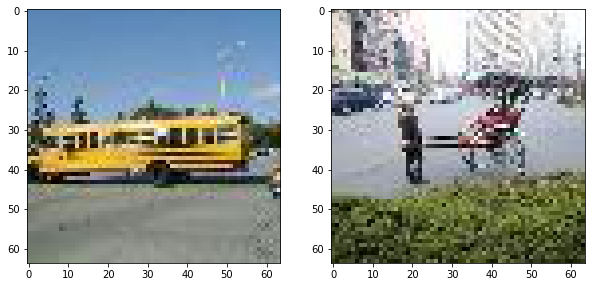

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import io
import torchvision
import cv2 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
import os
import torch
%matplotlib inline



# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = skimage.img_as_ubyte(io.imread('/content/tiny-imagenet-200/train/class_150/00001.jpg'))
plt.imshow(im)
plt.subplot(1,2,2)
mask = skimage.img_as_ubyte(io.imread('/content/tiny-imagenet-200/train/class_145/00006.jpg'))
plt.imshow(mask)


In [89]:
def read_files(X, Y, path):
  folders = os.listdir(path)
  for folder in tqdm(folders):
    files = os.listdir(path +'/' + folder)
    for file in files:
      img = cv2.imread(path +'/'+ folder + '/' + file)
      X.append(img)
      Y.append(int(folder[-3:]))
  return X, Y

In [90]:
from tqdm import tqdm
X = []
Y = []
X_t, Y_t = read_files(X, Y, "/content/tiny-imagenet-200/train")
X_v, Y_v = read_files(X, Y, "/content/tiny-imagenet-200/val")
print(len(X_t), len(Y_t))





  0%|          | 0/200 [00:00<?, ?it/s]



  1%|          | 2/200 [00:00<00:11, 17.49it/s]



  2%|▏         | 4/200 [00:00<00:11, 17.69it/s]



  3%|▎         | 6/200 [00:00<00:10, 17.70it/s]



  4%|▍         | 8/200 [00:00<00:11, 17.27it/s]



  5%|▌         | 10/200 [00:00<00:10, 17.72it/s]



  6%|▌         | 12/200 [00:00<00:10, 17.16it/s]



  7%|▋         | 14/200 [00:00<00:10, 17.13it/s]



  8%|▊         | 16/200 [00:00<00:10, 17.02it/s]



  9%|▉         | 18/200 [00:01<00:10, 17.27it/s]



 10%|█         | 20/200 [00:01<00:10, 17.43it/s]



 11%|█         | 22/200 [00:01<00:10, 17.67it/s]



 12%|█▏        | 24/200 [00:01<00:09, 17.69it/s]



 13%|█▎        | 26/200 [00:01<00:09, 17.45it/s]



 14%|█▍        | 28/200 [00:01<00:09, 17.58it/s]



 15%|█▌        | 30/200 [00:01<00:09, 17.54it/s]



 16%|█▌        | 32/200 [00:01<00:09, 17.79it/s]



 17%|█▋        | 34/200 [00:01<00:09, 17.63it/s]



 18%|█▊        | 36/200 [00:02<00:09, 17.77it/s]



 19%|█▉        | 38/2

110000 110000


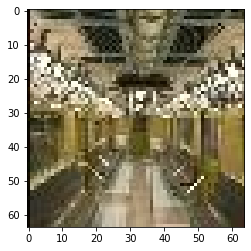

In [51]:
plt.imshow(skimage.img_as_ubyte(X_t[15]))

In [52]:
#Очень долго работает || 
#Поменял стратегию

# def read_files(X, Y, path):
#   folders = os.listdir(path)
#   for folder in tqdm(folders):
#     files = os.listdir(path +'/' + folder)
#     for file in files:
#       img = cv2.imread(path + '/' + folder + '/' + file, 0)
#       X = img if (X is None) else np.vstack((X, img)) 
#       Y = np.append(Y, int(folder[-3:]))
#         #print("done one image", "\n")
#   return X, Y

In [91]:
from torchvision import datasets, transforms as T
transform = T.Compose([T.ToTensor(),
                       T.CenterCrop(224),
                       T.Resize(256),
                       T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

In [92]:
class MyClass(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
    
    def __getitem__(self, i):
        picture = skimage.img_as_ubyte(self.X[i])
        if self.transform:
          picture = self.transform(picture)
        return picture, self.Y[i]

    def __len__(self):
        return len(self.X)

In [93]:
data_t = MyClass(X_t, Y_t, transform)
data_v = MyClass(X_v, Y_v, transform)
train_data, test_data = torch.utils.data.random_split(data_t, [int(0.8*len(data_t)), int(0.2*len(data_t))])


In [94]:
len(Y_t)

110000

In [95]:
import torchvision.models as models
vgg16 = models.vgg16(progress = True)

In [119]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [121]:
vgg16.classifier[6] = nn.Sequential(nn.Linear(4096, 200), nn.Softmax())

In [144]:
criterion = nn.CrossEntropyLoss()
lr = 1e-3
optimizer = torch.optim.Adam(vgg16.parameters(), lr)
vgg16.cuda()

train_losses = []
train_metrics = []

hist = {"train_loss": [],
        "train_auc": [],
        "train_acc": [],
        "val_loss": [],
        "val_auc": [],
        "val_acc": []}
from sklearn import metrics
from sklearn.metrics import accuracy_score


In [148]:
loader_train = DataLoader(dataset=train_data, batch_size=5, shuffle=True)
loader_val = DataLoader(dataset=data_v, batch_size=3)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
epochs = 50
vgg16.train()
for i in tqdm(range(epochs)):
      if i>0:
         print("Epoch %d/%d\t Loss mean: %f\t IoU mean: %f"% \
               (i, num_epochs, epoch_loss, epoch_iou))
         print("Epoch %d/%d\t Val Loss mean: %f\t Val IoU mean: %f"% \
               (i, num_epochs, val_loss, val_iou))
    
         plt.figure(figsize=(16, 6))
         plt.subplot(121)
         plt.plot(hist['train_loss'], label='train')
        #  plt.plot(hist['val_loss'], label='val')
         plt.legend()
         plt.grid()
        
         plt.subplot(122)
         plt.plot(hist['train_auc'], label='train_auc')
        #  plt.plot(hist['val_iou'], label='val_iou')
         plt.legend()
         plt.grid()
         plt.show()

      epoch_losses = []
      epoch_aucs = []
      epoch_acc_ = []

      for j, (x, y) in (enumerate(loader_train)):
          optimizer.zero_grad()
          x = x.cuda()
          y = y.cuda()
          y_pred = vgg16(x)
          loss = criterion(y_pred, y)
          loss.backward()
          optimizer.step()

          epoch_losses.append(loss.item())
          pred = [np.argmax(i) for i in y_pred.cpu().detach().numpy()]
          #auc = metrics.roc_auc_score(pred, y.cpu().detach().numpy())
          acc = accuracy_score(y.cpu().detach().numpy(), pred)

          epoch_aucs.append(auc)
          epoch_acc_.append(acc)
          
          
          if j%100 == 0:
              print("Epoch: %d \tLoss: %f"%(i+1, loss.item()))
      
      epoch_loss = np.mean(np.array(epoch_losses))
      epoch_auc = np.mean(np.array(epoch_aucs))
      hist['train_auc'].append(epoch_auc)
      hist['train_loss'].append(epoch_loss)
      hist['train_acc'].append(epoch_acc_)
      # with torch.no_grad():
      #     model.eval()
      #     for k, (img, mask) in enumerate(val_loader):
      #         y_pred = vgg16(img.cuda())
      #         loss = criterion(y_pred, mask.cuda())
      #         iou = calc_iou(y_pred.cpu().detach().numpy()>0.15, 
      #                               mask.numpy())
      #         val_losses.append(loss.item())
      #         val_ious.append(iou)
              
              
              
      # val_loss = np.mean(np.array(val_losses))
      # val_iou = np.mean(np.array(val_ious))
      # hist['val_loss'].append(val_loss)
      # hist['val_iou'].append(val_iou)
      if i < (num_epochs - 1):
          clear_output()







  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 	Loss: 5.298065
Epoch: 1 	Loss: 5.297997
Epoch: 1 	Loss: 5.299083
Epoch: 1 	Loss: 5.298118
Epoch: 1 	Loss: 5.298320
Epoch: 1 	Loss: 5.299886
Epoch: 1 	Loss: 5.294164
Epoch: 1 	Loss: 5.299607
Epoch: 1 	Loss: 5.300205
Epoch: 1 	Loss: 5.298974
Epoch: 1 	Loss: 5.299685
Epoch: 1 	Loss: 5.296319
Epoch: 1 	Loss: 5.300452
Epoch: 1 	Loss: 5.298040
Epoch: 1 	Loss: 5.298320
Epoch: 1 	Loss: 5.301136
Epoch: 1 	Loss: 5.297391
Epoch: 1 	Loss: 5.301238
Epoch: 1 	Loss: 5.298284
Epoch: 1 	Loss: 5.297738
Epoch: 1 	Loss: 5.298201
Epoch: 1 	Loss: 5.300200
Epoch: 1 	Loss: 5.298888
Epoch: 1 	Loss: 5.298092
Epoch: 1 	Loss: 5.298437
Epoch: 1 	Loss: 5.299701
Epoch: 1 	Loss: 5.300740
Epoch: 1 	Loss: 5.297649
Epoch: 1 	Loss: 5.298075
Epoch: 1 	Loss: 5.300039
Epoch: 1 	Loss: 5.297810
Epoch: 1 	Loss: 5.298728
Epoch: 1 	Loss: 5.298744
Epoch: 1 	Loss: 5.296337
Epoch: 1 	Loss: 5.297514
Epoch: 1 	Loss: 5.297349
Epoch: 1 	Loss: 5.299428
Epoch: 1 	Loss: 5.299515
Epoch: 1 	Loss: 5.298676
